<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [40]:
ticker = "PYPL"
look_back = 5 # 5 days Number of past days we want to use to predict the future.
max_data_size = 730 # 2 years
split_percent = 0.90 # use 90 of the data  for train
zoom = 180 # last 180 days see in chart

In [41]:
stock_api_response = pd.read_json('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T')
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);
#print(list(stock_api_data.items()))
data = []
for key, value in stock_api_data.items():
  data.append([
      key,
      value.get('1. open'),
      value.get('2. high'),
      value.get('3. low'),
      value.get('5. adjusted close'),
      value.get('6. volume')
      ])

last_data =  str(data[0][0])
print(data[0])
if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
print('data size:',len(data), 'max_data_size:', max_data_size)

['2021-10-22', '243.73', '246.66', '239.79', '240.4', '24139201']
data size: 730 max_data_size: 730


In [42]:
df = pd.DataFrame(data,columns=['Date','Open','High','Low','Close','Volume'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

657

In [43]:
df_train = df.iloc[:split]
df_test = df.iloc[split:]

trace1 = go.Candlestick(
    x = df_train['Date'],
    open = df_train['Open'],
    high = df_train['High'],
    low = df_train['Low'],
    close = df_train['Close'],
    name = 'Train'
)

trace2 = go.Candlestick(
    x = df_test['Date'],
    open = df_test['Open'],
    high = df_test['High'],
    low = df_test['Low'],
    close = df_test['Close'],
    increasing={'line': {'color': 'lightblue'}},
    decreasing={'line': {'color': 'purple'}},    
    name ='Test'
)

trace3 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace4 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

layout = go.Layout(
    title = ticker + ' Date:' + last_data + ' Open:' + str(data[-1][1]) + ' High:' + str(data[-1][2]) + ' Low:' + str(data[-1][3]) + ' Close:' + str(data[-1][4]),
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
fig.show(config=config)



fig1 = px.bar(
    x=df['Date'], 
    y=df['Volume'], 
    height=250, 
    labels={"x": "Dates","y": "Volume"},
    title=ticker)
fig1.show()

    Open    High    Low  Close
0  85.37  85.675  83.79  84.26
1  84.39  85.860  83.66  85.81
2  87.29  88.840  87.19  87.98
3  87.24  88.470  84.02  84.19
4  81.82  85.860  81.29  85.82
(657, 4)


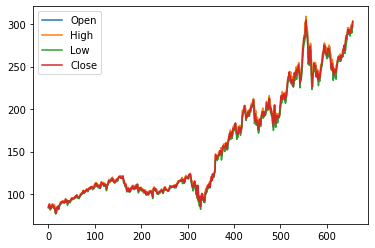

In [44]:
#Variables for training
#Date and volume columns are not used in training. 
df_for_training = df_train[['Open','High','Low','Close']].astype(float)
print(df_for_training.head())

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_plot=df_for_training
df_for_plot.plot.line()
print(df_for_training.shape)

In [45]:
def create_LSTM_input(df_with_features,n_past=6):
  #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
  #In this example, the n_features is 5. We will make timesteps = look_back (past days data used for training). 

  #Empty lists to be populated using formatted training data
  trainX = []
  trainY = []

  n_future = 1   # Number of days we want to look into the future based on the past days.


  #Reformat input data into a shape: (n_samples x timesteps x n_features)
  #In my example, my df_with_features has a shape (12823, 4)
  #12823 refers to the number of data points and 5 refers to the columns (multi-variables).
  for i in range(look_back, len(df_with_features) - n_future +1):
      trainX.append(df_for_training_scaled[i - look_back:i, 0:df_for_training.shape[1]])
      trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

  trainX, trainY = np.array(trainX), np.array(trainY)

  print('trainX shape == {}.'.format(trainX.shape))
  print('trainY shape == {}.'.format(trainY.shape))
  return trainX, trainY

In [46]:
trainX, trainY = create_LSTM_input(df_for_training_scaled,look_back)

trainX shape == (652, 5, 4).
trainY shape == (652, 1).


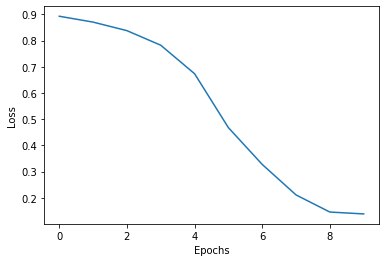

In [47]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation="tanh"))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))


#model = Sequential()
#model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(32, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(trainY.shape[1]))

model.compile(
    loss=MAE,
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mae"]
)
  
#model.summary()


# fit the model
modelo = model.fit(trainX, trainY, epochs=10, verbose=0)

plt.plot(modelo.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [48]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days
test_dates = pd.to_datetime(df_test['Date'])
print(df_test)
predict_period_dates = pd.date_range(list(test_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

           Date    Open      High  ...      50MA      100MA       200MA
657  2021-07-13  302.19    307.82  ...  268.9428  262.47525  242.217575
658  2021-07-14  303.01    304.81  ...  269.7760  262.61355  242.785075
659  2021-07-15  300.86    301.18  ...  270.7030  262.84015  243.307525
660  2021-07-16  297.23    298.75  ...  271.6476  263.13645  243.808175
661  2021-07-19  292.35  295.0693  ...  272.5042  263.42425  244.297275
..          ...     ...       ...  ...       ...        ...         ...
725  2021-10-18  266.39    270.44  ...  273.6524  278.83840  266.707825
726  2021-10-19  271.01    273.27  ...  273.5234  278.96070  266.906725
727  2021-10-20   273.0    273.51  ...  273.2032  278.94410  267.023975
728  2021-10-21  258.61    258.96  ...  272.5392  278.78350  267.105875
729  2021-10-22  243.73    246.66  ...  271.8554  278.56580  267.132675

[73 rows x 9 columns]
[Timestamp('2021-10-01 00:00:00', freq='C'), Timestamp('2021-10-04 00:00:00', freq='C'), Timestamp('2021-10-05 00

       Open      High       Low   Close
657  302.19  307.8200  298.7500  301.19
658  303.01  304.8100  299.3301  300.75
659  300.86  301.1800  294.1400  296.51
660  297.23  298.7500  294.4400  294.63
661  292.35  295.0693  288.8100  294.85
..      ...       ...       ...     ...
725  266.39  270.4400  264.7100  270.33
726  271.01  273.2700  269.8350  271.70
727  273.00  273.5100  253.1000  258.36
728  258.61  258.9600  242.9800  243.21
729  243.73  246.6600  239.7900  240.40

[73 rows x 4 columns]
(73, 4)


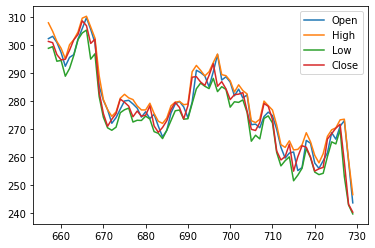

In [49]:
#Variables for training
#Date and volume columns are not used in training. 
df_for_test = df_test[['Open','High','Low','Close']].astype(float)
print(df_for_test)

df_for_plot=df_for_test
df_for_plot.plot.line()
print(df_for_test.shape)
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_test)
df_for_test_scaled = scaler.transform(df_for_test)

In [50]:
testX, testY = create_LSTM_input(df_for_test_scaled,look_back)

trainX shape == (68, 5, 4).
trainY shape == (68, 1).


In [51]:
#Make prediction
prediction = model.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction
print(prediction)
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_test.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

[[-0.9497889 ]
 [-0.9450398 ]
 [-0.93851763]
 [-0.94988143]
 [-0.95735556]
 [-0.955572  ]
 [-0.95024264]
 [-0.941449  ]
 [-0.93624073]
 [-0.93767035]
 [-0.94547915]
 [-0.9519708 ]
 [-0.9528587 ]
 [-0.96021014]
 [-0.9746256 ]
 [-0.9860227 ]
 [-0.98968714]
 [-0.97365594]
 [-0.96348715]
 [-0.95894736]
 [-0.95827806]
 [-0.9558849 ]
 [-0.95500576]
 [-0.9420604 ]
 [-0.9317785 ]
 [-0.92230403]
 [-0.9164926 ]
 [-0.91318804]
 [-0.9097827 ]
 [-0.90936244]
 [-0.9058613 ]
 [-0.90725625]
 [-0.91037637]
 [-0.9085731 ]
 [-0.90944535]
 [-0.90350884]
 [-0.89507043]
 [-0.88994694]
 [-0.89803433]
 [-0.9028946 ]
 [-0.9068141 ]
 [-0.9189485 ]
 [-0.9118572 ]
 [-0.9035856 ]
 [-0.90066636]
 [-0.9031822 ]
 [-0.9032192 ]
 [-0.8975329 ]
 [-0.8867683 ]
 [-0.8800953 ]
 [-0.877234  ]
 [-0.8781258 ]
 [-0.87459046]
 [-0.87481374]
 [-0.87306124]
 [-0.87033755]
 [-0.8646492 ]
 [-0.8594034 ]
 [-0.85762155]
 [-0.85179776]
 [-0.8478957 ]
 [-0.84788954]
 [-0.8577747 ]
 [-0.86098725]
 [-0.86244935]
 [-0.86439157]
 [-0.86322

In [54]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
print(len(forecast_dates),len(y_pred_future) )   
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df_train[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-8-1']

#sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])

15 68


ValueError: ignored